In [3]:
import os 
import matplotlib
import pandas  as pd 
import numpy as np
import seaborn as sns 

In [4]:
country_military_spending = pd.read_csv('military_spending_constant_2023.csv', sep = ',',    skiprows=5)
country_military_spending_2024 = country_military_spending[['Country','2024']]
country_military_spending_2024
us_spend = country_military_spending_2024[country_military_spending_2024['Country'] == 'United States of America'].copy()
other_countries_spend = country_military_spending_2024[country_military_spending_2024['Country'] != 'United States of America'].copy()
other_countries_spend = other_countries_spend.dropna()
other_countries_spend = other_countries_spend[other_countries_spend['2024'] != 'xxx']
other_countries_spend = other_countries_spend[other_countries_spend['2024'] != '...']
other_countries_spend['2024'] = np.array(other_countries_spend['2024'], dtype=float)
### Change US Spend to Billions


In [5]:
other_countries_spend = other_countries_spend.sort_values(by='2024', ascending = False)
other_countries_spend["cum_sum"] = other_countries_spend['2024'].cumsum()
needed = other_countries_spend[other_countries_spend["cum_sum"] < float(us_spend['2024'])]

needed_countries = needed['Country'].astype(str).tolist()
needed_spends = needed['2024'].astype(float).tolist()


## Change Spends to be in the order of billions
needed_spends = np.array(needed_spends)/1000
needed_spends = needed_spends.tolist()
us_spend['2024'] = float(us_spend['2024'])/1000

/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/3575772295.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  needed = other_countries_spend[other_countries_spend["cum_sum"] < float(us_spend['2024'])]
/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/3575772295.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  us_spend['2024'] = float(us_spend['2024'])/1000


/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/477789150.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.set_ylim(0, max(float(us_spend['2024']), sum(needed_spends)) * 1.15)
/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/477789150.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  us_val = float(us_spend[year_label])
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 

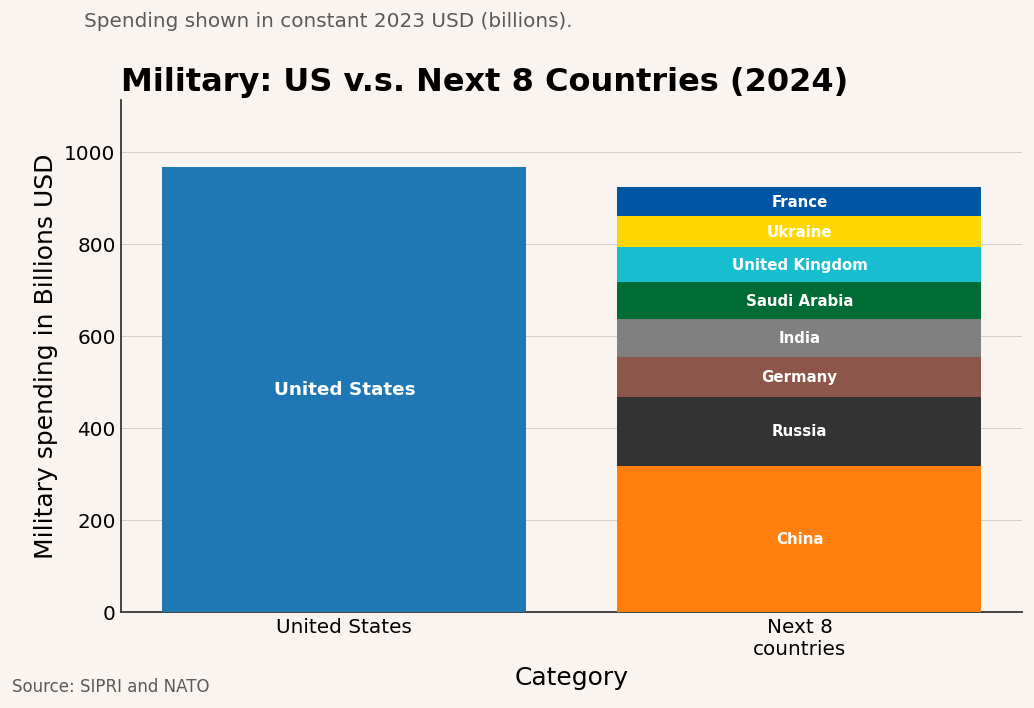

In [6]:
# ---- Plot: US vs stacked "Next N countries" ----
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -----------------------
# Economist / FT-like Matplotlib style
# -----------------------
def set_pubstyle_econ_ft(base_fontsize=12):
    mpl.rcParams.update({
        # Typography
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize * 1.6,
        "axes.labelsize": base_fontsize * 1.25,
        "legend.fontsize": base_fontsize * 0.95,
        "xtick.labelsize": base_fontsize * 1.0,
        "ytick.labelsize": base_fontsize * 1.0,

        # Lines & grid
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "axes.axisbelow": True,

        # Spines
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Figure
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",

        # Legend
        "legend.frameon": False,
        "legend.loc": "upper left",

        # Tick params
        "xtick.major.size": 0,
        "ytick.major.size": 0,
        "xtick.minor.size": 0,
        "ytick.minor.size": 0,
    })

def economist_axis_touches(ax):
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)
    ax.spines["left"].set_color("#3a3a3a")
    ax.spines["bottom"].set_color("#3a3a3a")
    ax.grid(axis="y", color="#8a8a8a")
    ax.grid(axis="x", visible=False)

def add_caption(fig, text, y_offset=0.02):
    fig.text(0.0, y_offset, text, ha="left", va="bottom", fontsize=10, color="#5a5a5a")

# -----------------------------------------
# Example data (replace with your real data)
# -----------------------------------------
year_label = "2024"  # keep consistent with title
#us_spend = {year_label: 916_000}  # millions, example only

#needed_countries = ["China", "Russia", "India", "UK", "Germany"]
#needed_spends =    [296_000, 109_000,  87_000,  74_000,   66_000]  # millions, example only

xtick_step = 1  # not crucial here, but kept in case you reuse

# -----------------------
# Build the plot
# -----------------------
set_pubstyle_econ_ft(base_fontsize=12)

fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")
ax = plt.gca()
ax.set_facecolor("#f9f4ef")

economist_axis_touches(ax)
ax.set_ylim(0, max(float(us_spend['2024']), sum(needed_spends)) * 1.15)

# Titles & labels
ax.set_xlabel("Category")
ax.set_ylabel("Military spending in Billions USD")
ax.set_title(f"Military: US v.s. Next 8 Countries ({year_label})", loc="left", fontweight="bold")

subtitle = "Spending shown in constant 2023 USD (billions)."

fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

# X axis ticks (no real 'years' here, so use a neutral locator)
ax.xaxis.set_major_locator(mticker.FixedLocator([0, 1]))
country_colors = {
    "Russia": "#333333",                  # near-black
    "China": "#FF7F0E",                   # orange
    "United States of America": "#1f77b4",# strong blue
    "United Kingdom": "#17becf",          # cyan / teal
    "France": "#0055A4",                  # deep flag blue
    "Ukraine": "#FFD700",                 # golden yellow
    "Germany": "#8c564b",                 # brownish gray
    "Saudi Arabia": "#006C35"             # emerald green
}



# Bars
x_positions = [0, 1]
us_name = "United States"

us_val = float(us_spend[year_label])
us_bar = ax.bar(x_positions[0], us_val, zorder=3, color="#1F77B4")  # optional color
# Put label in the middle of the bar
ax.text(
    x_positions[0], us_val/2, us_name,
    ha="center", va="center", fontsize=11, color="white", fontweight="bold"
)

bottom = 0.0
for cname, cval in zip(needed_countries, needed_spends):
    bar = ax.bar(
        x_positions[1], cval, bottom=bottom, zorder=3,
        color=country_colors.get(cname, "gray")  # fallback if not mapped
    )
    
    # Position text in the middle of the segment
    ax.text(
        x_positions[1], bottom + cval/2, cname,
        ha="center", va="center", fontsize=9, color="white", fontweight="bold"
    )
    
    bottom += cval

# X tick labels (two-line label for the right bar)
ax.set_xticks(x_positions)
ax.set_xticklabels([us_name, f"Next {len(needed_countries)}\ncountries"])

# Legend (list stacked countries clearly)
#ax.legend(title="Stacked countries", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)

# Caption/source (optional)
add_caption(fig, "Source: SIPRI and NATO")

plt.tight_layout(rect=[0, 0, 0.86, 0.95])  # leave room for the outside legend & suptitle
plt.savefig(fname = 'total_military_spending_comparison.png',dpi = 1000)

plt.show()


In [7]:

# NATO members (as listed in your dataset — adjust names if needed)
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Turkey", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czech Republic",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Latvia", "Lithuania", "Croatia", "Albania", "Montenegro", "North Macedonia"
]

# List of European NATO countries (exclude US & Canada)
# European NATO members
european_nato = [
    "Albania",
    "Belgium",
    "Bulgaria",
    "Croatia",
    "Czechia",
    "Denmark",
    "Estonia",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Montenegro",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Slovakia",
    "Slovenia",
    "Spain",
    "United Kingdom",
    "Türkiye"   # transcontinental but NATO member, listed as "Türkiye" in SIPRI
]



# Canada
canada_nato = ["Canada"]

# United States
us_nato = ["United States of America"]


# Load dataset
country_military_spending = pd.read_csv(
    "military_expenditures_in_shared_of_gdp.tsv",
    sep="\t",
    skiprows=5
)

# Keep only NATO members
nato_spending = country_military_spending[
    country_military_spending["Country"].isin(nato_countries)
]

us_military_spending = country_military_spending[
    country_military_spending["Country"].isin(us_nato)
]


# Reshape to long format
nato_long = nato_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Keep only numeric years
nato_long = nato_long[nato_long["Year"].str.isnumeric()]
nato_long["Year"] = nato_long["Year"].astype(int)
nato_long = nato_long[nato_long["Spending"] != "..."]

nato_long["Spending"] = (
    nato_long["Spending"]
    .replace(r"%", "", regex=True)
    .astype(float)
)
nato_long["Spending"] = nato_long["Spending"].astype(float)
europe_long = nato_long[nato_long["Country"].isin(european_nato)]



us_long = us_military_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Convert Year to int (if they are strings)
us_long = us_long[us_long["Year"].str.isnumeric()]

us_long["Year"] = us_long["Year"].astype(int)
us_long["Spending"] = (
    us_long["Spending"]
    .replace(r"%", "", regex=True)
    .astype(float)
)
us_long["Spending"] = us_long["Spending"].astype(float)

# Build a long-form dataframe for ALL countries (no NATO filter)



all_long = country_military_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Clean it the same way
all_long = all_long[all_long["Year"].astype(str).str.isnumeric()].copy()
all_long["Year"] = all_long["Year"].astype(int)

all_long = all_long[~all_long["Spending"].isin(["...", ". ."])].copy()
all_long["Spending"] = (
    all_long["Spending"].astype(str)
    .str.replace("%", "", regex=False)
    .str.strip()
)
all_long = all_long[pd.to_numeric(all_long["Spending"], errors="coerce").notna()].copy()
all_long["Spending"] = all_long["Spending"].astype(float)

# Russia & China series (averages per year in case of duplicates)
russia_avg = (
    all_long[all_long["Country"] == "Russia"]
    .groupby("Year")["Spending"].mean().reset_index()
)
china_avg = (
    all_long[all_long["Country"] == "China"]
    .groupby("Year")["Spending"].mean().reset_index()
)






findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

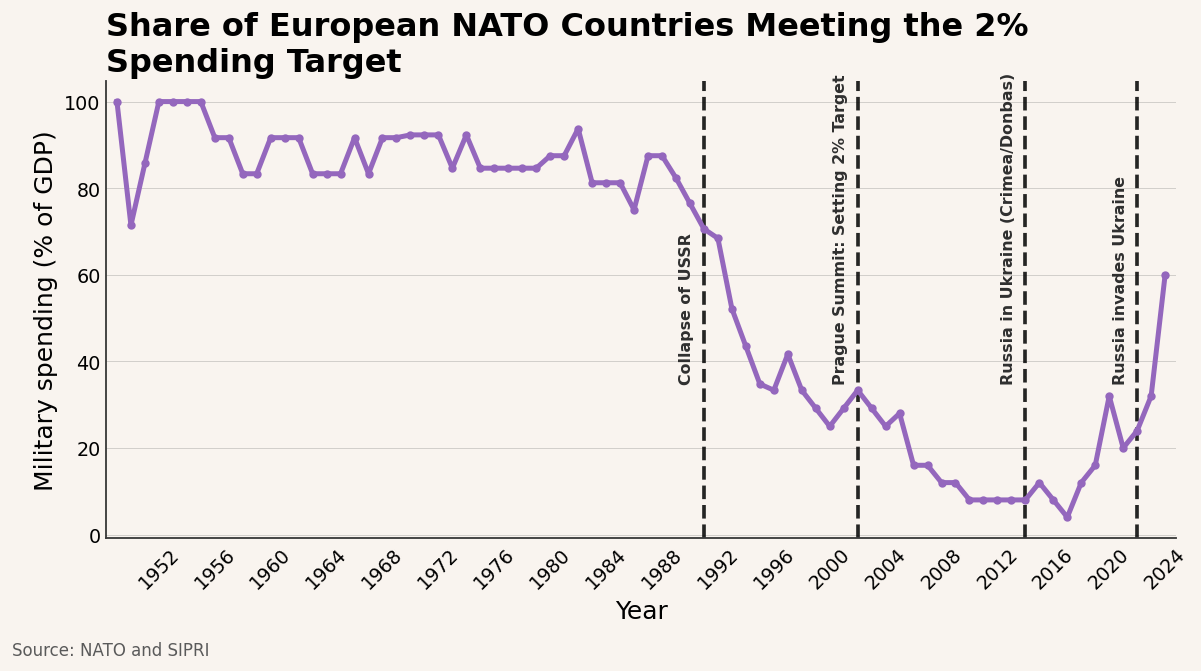

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to European NATO countries
eu = nato_long[nato_long["Country"].isin(european_nato)].copy()

# For each year: percentage of countries with Spending >= 2 (only among countries with data that year)
eu_yearly = (
    eu.groupby("Year")["Spending"]
      .agg(total=lambda s: s.notna().sum(),
           hits=lambda s: (s >= 2).sum())
      .reset_index()
)
eu_yearly["pct_above_2"] = eu_yearly["hits"] / eu_yearly["total"] * 100

# Plot
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area
set_pubstyle_econ_ft(base_fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=14)
economist_axis_touches(ax)
ax.plot(
    eu_yearly["Year"], eu_yearly["pct_above_2"],
    linewidth=3, marker="o", markersize=4, color="#9467BD",  # purple (colorblind-friendly)
    label="European NATO at ≥ 2%"
)

events = [
    (1991, "Collapse of USSR"),
    (2002, "Prague Summit: Setting 2% Target"),
    (2014, "Russia in Ukraine (Crimea/Donbas)"),
    (2022, "Russia invades Ukraine")
]


# Draw the vertical lines
for x, _ in events:
    ax.axvline(x=x, color="black", linestyle="--", linewidth=2.2, alpha=0.85, zorder=1)

# Place labels *inside* the plot, close to bottom
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.1 * (ymax - ymin)   # 10% above bottom

for x, label in events:
    ax.text(
        x - 1.75, label_y + 25,
        label,
        rotation=90,
        fontsize=9.5,
        va="bottom", ha="left",
        color="#2f2f2f", weight = 'bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )
# Formatting
#ax.title("Share of European NATO Countries Meeting the 2% Guideline", fontsize=18, fontweight="bold")


subtitle = "Spending shown in constant 2023 USD (billions)."


ax.set_title(f"Share of European NATO Countries Meeting the 2% \nSpending Target", loc="left", fontweight="bold")
#fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

ax.set_xlabel("Year")
ax.set_ylabel("Military spending (% of GDP)")



# Ticks: nice integer years if your x is datetime/int; adjust as needed
ax.margins(x=0.01)
ax.tick_params(axis="both", which="major", labelsize=11.5)

# Caption / source note
add_caption(fig, "Source: NATO and SIPRI")
import matplotlib.ticker as mticker

# Get current number of ticks
import matplotlib.ticker as mticker

# Get how many ticks you currently have
num_ticks = len(ax.get_xticks())

# Request roughly double
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=num_ticks * 2))
ax.tick_params(axis="x", rotation=45)   # rotate all x tick labels
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.savefig(fname = 'european_countries_meeting_2_percent_target.png',dpi = 1000)

plt.show()

In [ ]:
import pandas as pd

# Load the CSV
file_path = "social_spending_ssocx.csv"
df = pd.read_csv(file_path)

# Select and rename relevant columns
df_clean = df[["Reference area", "TIME_PERIOD", "OBS_VALUE"]].rename(
    columns={
        "Reference area": "Country",
        "TIME_PERIOD": "Year",
        "OBS_VALUE": "Public social spending (% of GDP)"
    }
)

# Convert year to integer
df_clean["Year"] = df_clean["Year"].astype(int)

# Convert spending to numeric
df_clean["Public social spending (% of GDP)"] = pd.to_numeric(df_clean["Public social spending (% of GDP)"], errors="coerce")

print(df_clean.head())
df_clean = df_clean.dropna()
df_clean

   Country  Year  Public social spending (% of GDP)
0  Romania  1980                                NaN
1  Romania  1981                                NaN
2  Romania  1982                                NaN
3  Romania  1983                                NaN
4  Romania  1984                                NaN


findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

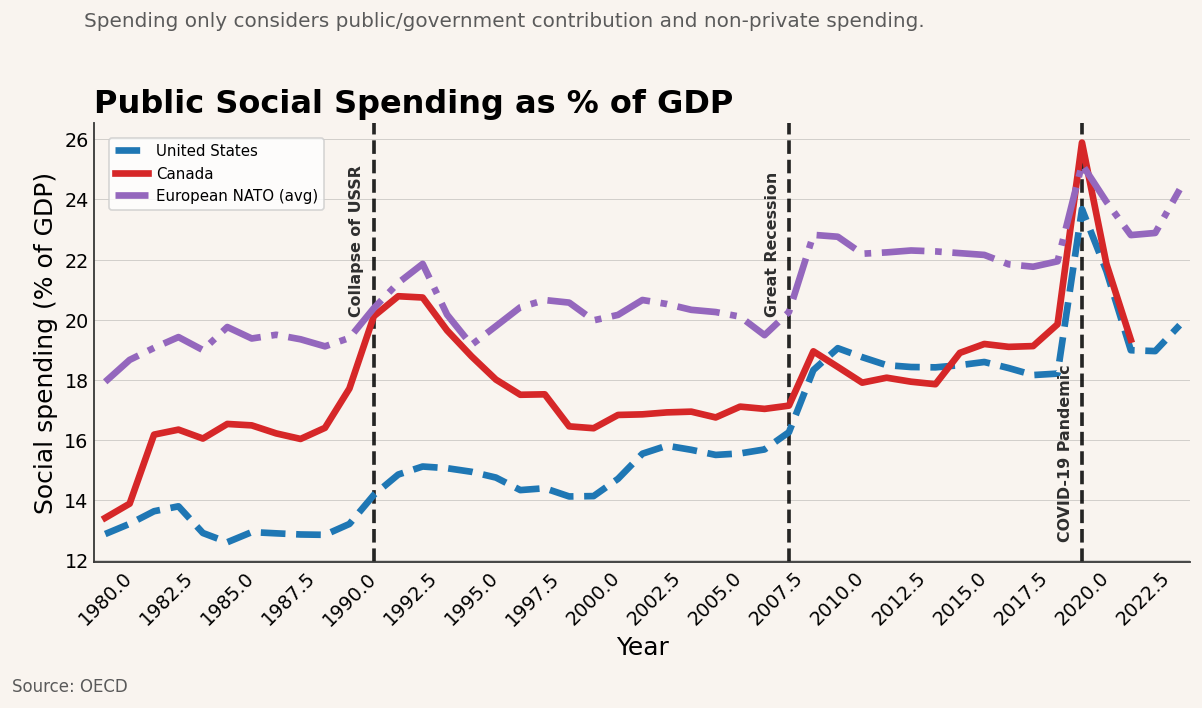

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_clean

# Full NATO list you gave
nato_countries = [
    "United States", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Turkey", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czech Republic",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Latvia", "Lithuania", "Croatia", "Albania", "Montenegro", "North Macedonia"
]

# Filter only NATO countries present in dataset
df_nato = df[df["Country"].isin(nato_countries)].copy()

# Filter for Year >= 1949
df_nato = df_nato[df_nato["Year"] >= 1949]

# Split categories
us = df_nato[df_nato["Country"] == "United States"]
us = us.sort_values(by = 'Year')
canada = df_nato[df_nato["Country"] == "Canada"]
canada = canada.sort_values(by = 'Year')

# European subset (exclude US and Canada)
europe = df_nato[~df_nato["Country"].isin(["United States","Canada"])]
europe = europe.sort_values(by = 'Year')

# Compute average across European NATO members by year
europe_avg = europe.groupby("Year")["Public social spending (% of GDP)"].mean().reset_index()

# Plot
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area
set_pubstyle_econ_ft(base_fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=14)
economist_axis_touches(ax)


events = [
    (1991, "Collapse of USSR"),
   # (2001, "US invades Afghanistan"),
    (2008, "Great Recession"),
    (2020, "COVID-19 Pandemic"),
]


# Draw the vertical lines
for x, _ in events:
    ax.axvline(x=x, color="black", linestyle="--", linewidth=2.2, alpha=0.85, zorder=1)

# Place labels *inside* the plot, close to bottom
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.1 * (ymax - ymin)   # 10% above bottom


for x, label in events:
    if x != 2020:
        ax.text(
            x - 1., label_y + 20,
            label,
            rotation=90,
            fontsize=9.5,
            va="bottom", ha="left",
            color="#2f2f2f", weight = 'bold',
            bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
            zorder=5
        )
    else:
        ax.text(
            x - 1., label_y + 12.5,
            label,
            rotation=90,
            fontsize=9.5,
            va="bottom", ha="left",
            color="#2f2f2f", weight = 'bold',
            bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
            zorder=5
        )
# Formatting
#ax.title("Share of European NATO Countries Meeting the 2% Guideline", fontsize=18, fontweight="bold")



ax.plot(us["Year"], us["Public social spending (% of GDP)"], label="United States", color="#1F77B4",linestyle="--",linewidth=4,)
ax.plot(canada["Year"], canada["Public social spending (% of GDP)"], label="Canada", color="#D62728",linewidth=4,)
ax.plot(europe_avg["Year"], europe_avg["Public social spending (% of GDP)"], label="European NATO (avg)",color="#9467BD", linewidth=4, linestyle="-.",)
ax.set_title(f"Public Social Spending as % of GDP", loc="left", fontweight="bold")


ax.set_xlabel("Year")
ax.set_ylabel("Social spending (% of GDP)")


subtitle = "Spending only considers public/government contribution and non-private spending."

fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

#fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

ax.set_xlabel("Year")
leg = ax.legend(
    ncol=1,
    frameon=True,        # show background panel
    facecolor="white",   # solid white background
    edgecolor="#cccccc", # subtle gray border
    handlelength=2.2,
    handletextpad=0.5,
    borderaxespad=1.0,
    loc="upper left",
    fontsize=9
)

# Ticks: nice integer years if your x is datetime/int; adjust as needed
ax.margins(x=0.01)
ax.tick_params(axis="both", which="major", labelsize=11.5)

# Caption / source note
add_caption(fig, "Source: OECD ")
import matplotlib.ticker as mticker

# Get current number of ticks
import matplotlib.ticker as mticker

# Get how many ticks you currently have
num_ticks = len(ax.get_xticks())

# Request roughly double
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=num_ticks * 2))
ax.tick_params(axis="x", rotation=45)   # rotate all x tick labels
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.savefig(fname = 'nato_countries_social_spending.png',dpi = 1000)

plt.show()

   Country  Year  Public social spending (% of GDP)
0  Romania  1980                                NaN
1  Romania  1981                                NaN
2  Romania  1982                                NaN
3  Romania  1983                                NaN
4  Romania  1984                                NaN


,Country,Year,Public social spending (% of GDP)
91,Norway,2006,19.404
92,Norway,2007,19.520
93,Norway,2008,19.169
94,Norway,2009,22.415
95,Norway,2010,22.001
...,...,...,...
1901,Costa Rica,2018,12.434
1902,Costa Rica,2019,12.326
1903,Costa Rica,2020,14.372
1904,Costa Rica,2021,12.701


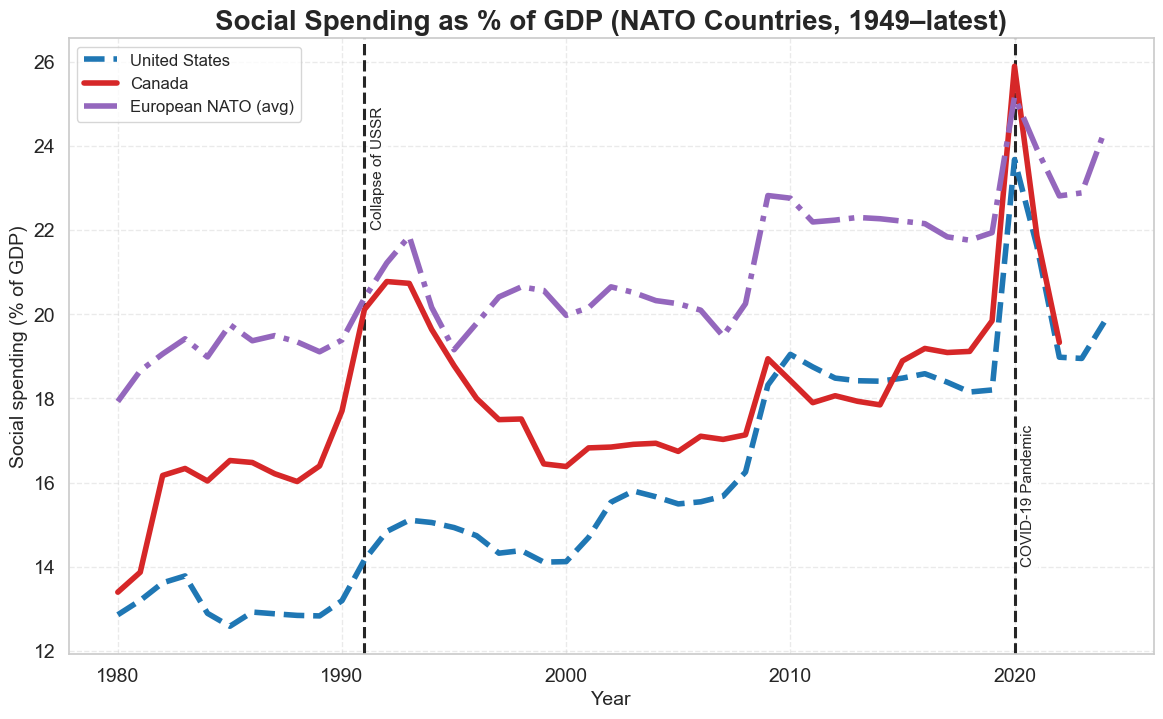

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt




set_pubstyle()
plt.figure()


]
ax = plt.gca()

# Draw the vertical lines
for x, _ in events:
    ax.axvline(x=x, color="black", linestyle="--", linewidth=2.2, alpha=0.85, zorder=1)

# Place labels *inside* the plot, close to bottom
ymin, ymax = ax.get_ylim()
#label_y = ymin + 0.1 * (ymax - ymin)   # 10% above bottom

for i, (x, label) in enumerate(events):
    if x == 2020:
        ax.text(
        x + 0.3, 14,
        label,
        rotation=90,               # vertical text looks tidy near lines
        fontsize=11,
        va="bottom", ha="left",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=2),
        zorder=5
    )
    else:
        ax.text(
            x + 0.3, 22,
            label,
            rotation=90,               # vertical text looks tidy near lines
            fontsize=11,
            va="bottom", ha="left",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=2),
            zorder=5
        )


# Plot


findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

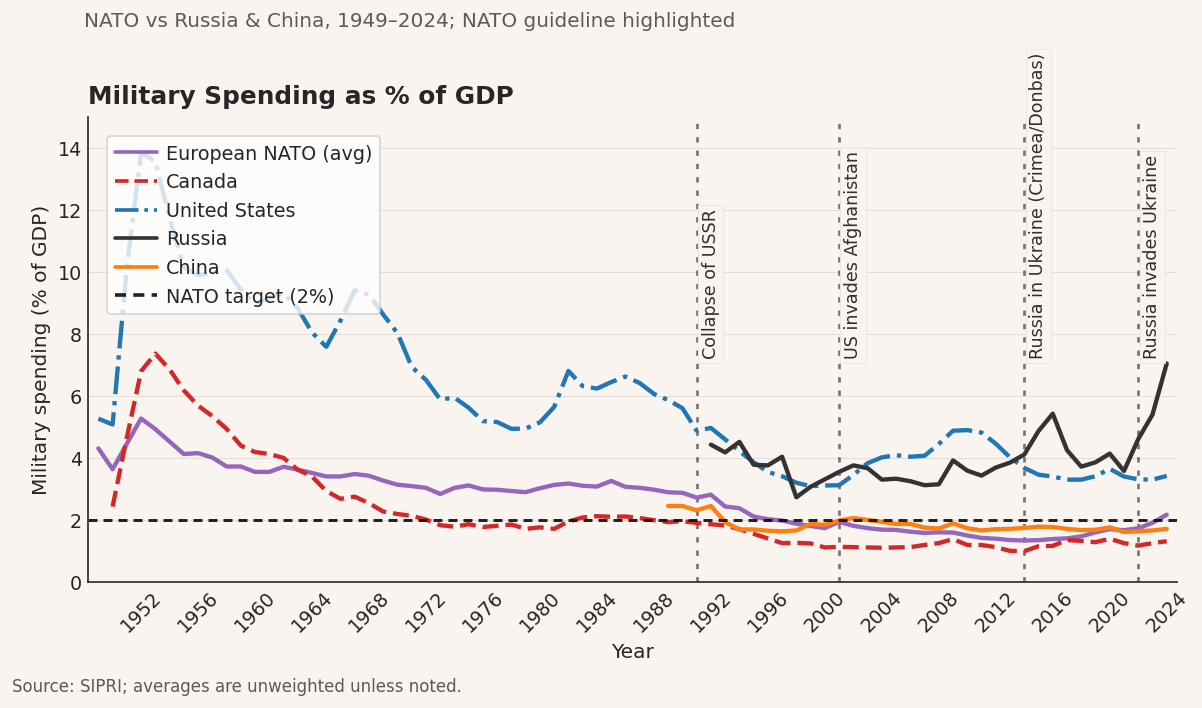

In [159]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# -----------------------
# Economist / FT-like Matplotlib style
# -----------------------
def set_pubstyle_econ_ft(base_fontsize=12):
    mpl.rcParams.update({
        # Typography
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],  
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize * 1.6,
        "axes.labelsize": base_fontsize * 1.25,
        "legend.fontsize": base_fontsize * 0.95,
        "xtick.labelsize": base_fontsize * 1.0,
        "ytick.labelsize": base_fontsize * 1.0,

        # Lines & grid
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "axes.axisbelow": True,

        # Spines
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Figure
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",

        # Legend
        "legend.frameon": False,
        "legend.loc": "upper left",

        # Tick params
        "xtick.major.size": 0,
        "ytick.major.size": 0,
        "xtick.minor.size": 0,
        "ytick.minor.size": 0,
    })
    
def economist_axis_touches(ax):
    # Subtle, slightly thicker left/bottom spines like FT/Economist
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)
    ax.spines["left"].set_color("#3a3a3a")
    ax.spines["bottom"].set_color("#3a3a3a")
    ax.grid(axis="y", color="#8a8a8a")
    ax.grid(axis="x", visible=False)

def add_caption(fig, text, y_offset=0.02):
    # Small gray source/caption at the bottom-left
    fig.text(
        0.0, y_offset, text,
        ha="left", va="bottom",
        fontsize=10, color="#5a5a5a"
    )

# -----------------------
# Plot with Russia & China (colorblind-friendly palette)
# -----------------------
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area


# European NATO average (purple)
ax.plot(
    europe_mean.index, europe_mean.values,
    linewidth=2.6, color="#9467BD", label="European NATO (avg)"
)

# Canada (red, dashed)
ax.plot(
    canada_avg["Year"], canada_avg["Spending"],
    linewidth=2.6, linestyle="--", color="#D62728", label="Canada"
)

# United States (blue, dash-dot)
ax.plot(
    us_avg["Year"], us_avg["Spending"],
    linewidth=2.6, linestyle="-.", color="#1F77B4", label="United States"
)

# Russia (near-black)
ax.plot(
    russia_avg["Year"], russia_avg["Spending"],
    linewidth=2.6, color="#333333", label="Russia"
)

# China (orange)
ax.plot(
    china_avg["Year"], china_avg["Spending"],
    linewidth=2.6, color="#FF7F0E", label="China"
)

# NATO guideline
ax.axhline(2, color="#0c0c0c", linestyle=(0, (3, 2)), linewidth=1.8, alpha=0.9, label="NATO target (2%)")

# Event markers (thin, tidy, labeled)
events = [
    (1991, "Collapse of USSR"),
    (2001, "US invades Afghanistan"),
    (2014, "Russia in Ukraine (Crimea/Donbas)"),
    (2022, "Russia invades Ukraine"),
]

for x, _ in events:
    ax.axvline(x=x, color="#2f2f2f", linestyle=(0, (2, 3)), linewidth=1.6, alpha=0.65, zorder=1)

ymin, ymax = ax.get_ylim()
label_y = ymin + 0.06 * (ymax - ymin)   # low, but inside the chart

for x, label in events:
    ax.text(
        x + 0.35, label_y+6,
        label,
        rotation=90,
        fontsize=10.5,
        va="bottom", ha="left",
        color="#2f2f2f",
        bbox=dict(facecolor="#f9f4ef", edgecolor="#e5e5e5", linewidth=0.6, alpha=0.92, pad=2.2),
        zorder=5
    )

# Axes formatting
economist_axis_touches(ax)
ax.set_ylim(0, 15)
ax.set_xlabel("Year")
ax.set_ylabel("Military spending (% of GDP)")

# Title + subtitle (FT/Economist style: bold title, lighter subtitle)
title = "Military Spending as % of GDP"
subtitle = "NATO vs Russia & China, 1949–2024; NATO guideline highlighted"
ax.set_title(title, loc="left", fontweight="bold", pad=8)
fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

# Legend (with opaque background for clarity)
leg = ax.legend(
    ncol=1,
    frameon=True,        # show background panel
    facecolor="white",   # solid white background
    edgecolor="#cccccc", # subtle gray border
    handlelength=2.2,
    handletextpad=0.5,
    borderaxespad=1.0,
    loc="upper left",
    fontsize=11.5
)

# Standardize line thickness inside legend
for line in leg.get_lines():
    line.set_linewidth(2.2)

# Ticks: nice integer years if your x is datetime/int; adjust as needed
ax.margins(x=0.01)
ax.tick_params(axis="both", which="major", labelsize=11.5)

# Caption / source note
add_caption(fig, "Source: SIPRI; averages are unweighted unless noted.")
import matplotlib.ticker as mticker

# Get current number of ticks
import matplotlib.ticker as mticker

# Get how many ticks you currently have
num_ticks = len(ax.get_xticks())

# Request roughly double
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=num_ticks * 2))
ax.tick_params(axis="x", rotation=45)   # rotate all x tick labels
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.show()


In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -----------------------
# Helpers
# -----------------------
def _to_number_percent(series_like):
    """Convert numbers or strings like '6.05%' / '6,05 %' to float (6.05)."""
    s = pd.Series(series_like, copy=True)
    s = s.astype(str).str.replace("%", "", regex=False).str.replace(",", "", regex=False).str.strip()
    return pd.to_numeric(s, errors="coerce")

def _ensure_year_index(x):
    """Coerce a sequence/Index of years to int (if datetime-like, take .year)."""
    if isinstance(x, pd.Index):
        vals = x
    else:
        vals = pd.Index(x)
    if np.issubdtype(vals.dtype, np.datetime64):
        return pd.Index(vals.year.astype(int), name=vals.name)
    try:
        return pd.Index(pd.to_numeric(vals, errors="coerce").astype("Int64").astype(int), name=vals.name)
    except Exception:
        return vals

# -----------------------
# Main plotter
# -----------------------
def plot_euro_spaghetti_clean(
    nato_long,                # DataFrame: Country, Year, Spending
    european_nato,            # iterable[str]
    europe_mean,              # pd.Series indexed by Year with the European average
    events,                   # list[(year_int, label)]
    *,
    smooth_years=3,           # rolling window; use 0 or 1 to disable
    winsor=(0.01, 0.99),      # clip extremes (quantiles) to avoid scale blowup; set None to disable
    xtick_step=4,             # years between major ticks
    figsize=(10, 6.2),
    base_font=11,
    highlight=None            # optional list of countries to emphasize in color
):
    highlight = set(highlight or [])

    # --- Theme (professional sans stack)
    plt.rcParams.update({
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],
        "font.size": base_font,
        "axes.titlesize": base_font * 1.35,
        "axes.labelsize": base_font * 1.1,
        "legend.fontsize": base_font,
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.5,
        "grid.alpha": 0.25,
        "axes.axisbelow": True,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "savefig.bbox": "tight",
        "figure.dpi": 120,
        "savefig.dpi": 300,
    })

    # --- Clean input
    df = nato_long.copy()
    df = df[df["Country"].isin(european_nato)]
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    df["Spending"] = _to_number_percent(df["Spending"])
    df = df.dropna(subset=["Year", "Spending"]).astype({"Year": int})

    # european average series cleanup
    emean = pd.Series(europe_mean.values, index=europe_mean.index)
    emean.index = _ensure_year_index(emean.index)
    emean = pd.to_numeric(_to_number_percent(emean), errors="coerce")
    emean = emean.dropna().sort_index()

    # optional smoothing
    if smooth_years and smooth_years > 1:
        df = (df.sort_values(["Country", "Year"])
                .groupby("Country", group_keys=False)
                .apply(lambda g: g.assign(
                    Spending=g["Spending"].rolling(int(smooth_years), min_periods=1, center=True).mean()
                )))

    # pivot for spread stats
    wide = (df.pivot(index="Year", columns="Country", values="Spending")
              .sort_index())

    # optional winsorization to tame outliers
    if winsor:
        lo_q, hi_q = winsor
        lo = np.nanquantile(wide.values, lo_q)
        hi = np.nanquantile(wide.values, hi_q)
        wide = wide.clip(lower=lo, upper=hi)

    q25 = wide.quantile(0.25, axis=1)
    q75 = wide.quantile(0.75, axis=1)

    # --- Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor("white")
    ax.grid(True, axis="y")
    ax.grid(False, axis="x")

    # faint per-country lines (neutral grey)
    for c in sorted(wide.columns):
        col = "#7f7f7f"
        alpha = 0.18
        lw = 0.9
        z = 2
        if c in highlight:
            col = "#1F77B4"
            alpha = 0.7
            lw = 1.8
            z = 4
        ax.plot(wide.index, wide[c].values, color=col, linewidth=lw, alpha=alpha, zorder=z, label = c)

    # IQR band (adds structure without clutter)
    ax.fill_between(wide.index, q25.values, q75.values,
                    color="#c9b6e6", alpha=0.25, linewidth=0, zorder=3, label="IQR (25–75%)")

    # European average on top
    ax.plot(emean.index, emean.values,
            color="#6f42c1", linewidth=3.0, zorder=5, label="Europe (avg)")

    # 2% NATO target
    ax.axhline(2, color="#222", linestyle=(0, (3, 2)), linewidth=1.4, alpha=0.85, zorder=4, label="NATO target (2%)")

    # restrained event markers + small labels near top
    for x, _ in events:
        ax.axvline(x=x, color="#444", linestyle=(0, (2, 3)), linewidth=1.0, alpha=0.35, zorder=1)

    ymin, ymax = ax.get_ylim()
    label_y = ymin + 0.9 * (ymax - ymin)
    for x, label in events:
        ax.text(x + 0.3, label_y, label, rotation=90, fontsize=base_font * 0.9,
                va="top", ha="left", color="#444",
                bbox=dict(facecolor="white", edgecolor="#ddd", linewidth=0.6, alpha=0.9, pad=2),
                zorder=6)

    # labels & ticks
    ax.set_xlabel("Year")
    ax.set_ylabel("Military spending (% of GDP)")
    ax.set_title("European NATO Military Spending (% of GDP) — Countries + Average", loc="left", fontweight="bold")
    fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

    ax.xaxis.set_major_locator(mticker.MultipleLocator(xtick_step))
    ax.tick_params(axis="x", rotation=45)
    ax.margins(x=0.01)

    # lean legend
    leg = ax.legend(loc="upper left", frameon=True, facecolor="white", edgecolor="#ddd")
    for line in leg.get_lines():
        line.set_linewidth(2.0)

    fig.tight_layout()
    return fig, ax

# -----------------------
# Example usage (drop-in)
# -----------------------
# want_spaghetti = True
# if want_spaghetti:
#     fig, ax = plot_euro_spaghetti_clean(
#         nato_long=nato_long,
#         european_nato=european_nato,
#         europe_mean=europe_mean,
#         events=events,
#         smooth_years=3,      # try 0, 3, or 5
#         winsor=(0.01, 0.99), # set to None to disable
#         xtick_step=4,
#         base_font=11,
#         highlight=["Poland", "Germany"]  # optional
#     )
#     plt.show()


/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_53220/3458534175.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.sort_values(["Country", "Year"])
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato

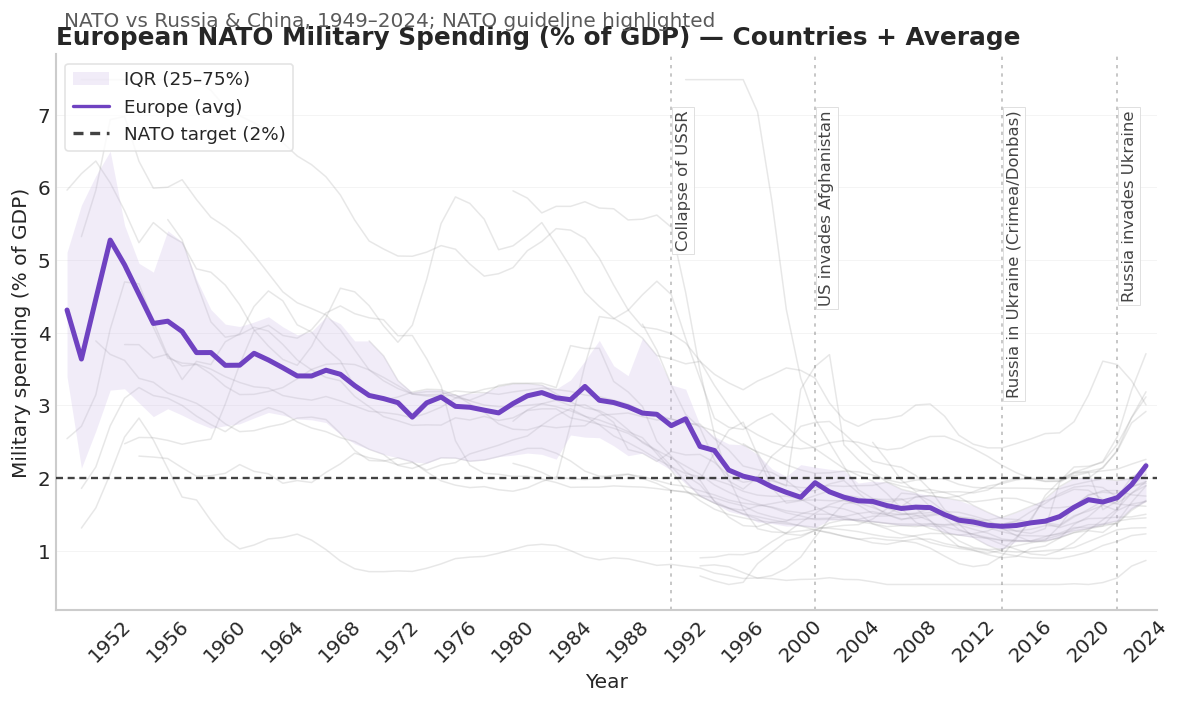

In [149]:
want_spaghetti = True
if want_spaghetti:
     fig, ax = plot_euro_spaghetti_clean(
         nato_long=nato_long,
         european_nato=european_nato,
         europe_mean=europe_mean,
         events=events,
         smooth_years=3,      # try 0, 3, or 5
         winsor=(0.01, 0.99), # set to None to disable
         xtick_step=4,
         base_font=11,
         #highlight=["Poland", "Germany"]  # optional
     )
     plt.show()


/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_53220/2283668737.py:88: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.sort_values(["Country", "Year"])
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato

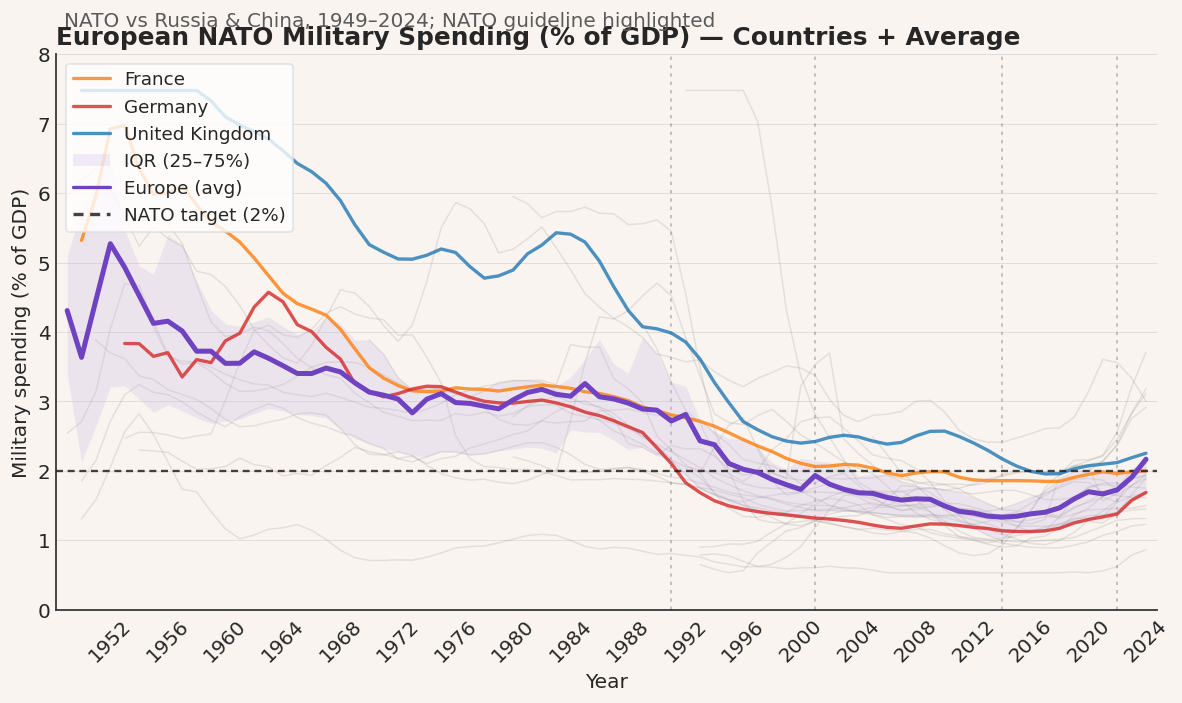

In [168]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# -----------------------
# Economist / FT-like Matplotlib style
# -----------------------
def set_pubstyle_econ_ft(base_fontsize=12):
    mpl.rcParams.update({
        # Typography
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],  
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize * 1.6,
        "axes.labelsize": base_fontsize * 1.25,
        "legend.fontsize": base_fontsize * 0.95,
        "xtick.labelsize": base_fontsize * 1.0,
        "ytick.labelsize": base_fontsize * 1.0,

        # Lines & grid
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "axes.axisbelow": True,

        # Spines
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Figure
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",

        # Legend
        "legend.frameon": False,
        "legend.loc": "upper left",

        # Tick params
        "xtick.major.size": 0,
        "ytick.major.size": 0,
        "xtick.minor.size": 0,
        "ytick.minor.size": 0,
    })
    
def economist_axis_touches(ax):
    # Subtle, slightly thicker left/bottom spines like FT/Economist
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)
    ax.spines["left"].set_color("#3a3a3a")
    ax.spines["bottom"].set_color("#3a3a3a")
    ax.grid(axis="y", color="#8a8a8a")
    ax.grid(axis="x", visible=False)

def add_caption(fig, text, y_offset=0.02):
    # Small gray source/caption at the bottom-left
    fig.text(
        0.0, y_offset, text,
        ha="left", va="bottom",
        fontsize=10, color="#5a5a5a"
    )

# -----------------------
# Plot with Russia & China (colorblind-friendly palette)
# -----------------------
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area


df = nato_long.copy()
df = df[df["Country"].isin(european_nato)]
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Spending"] = _to_number_percent(df["Spending"])
df = df.dropna(subset=["Year", "Spending"]).astype({"Year": int})

# european average series cleanup
emean = pd.Series(europe_mean.values, index=europe_mean.index)
emean.index = _ensure_year_index(emean.index)
emean = pd.to_numeric(_to_number_percent(emean), errors="coerce")
emean = emean.dropna().sort_index()
smooth_years=3      # try 0, 3, or 5
winsor=(0.01, 0.99) # set to None to disable
xtick_step=4
figsize=(10, 6.2)
highlight = ['Germany', 'France','United Kingdom']
# optional smoothing
if smooth_years and smooth_years > 1:
    df = (df.sort_values(["Country", "Year"])
            .groupby("Country", group_keys=False)
            .apply(lambda g: g.assign(
                Spending=g["Spending"].rolling(int(smooth_years), min_periods=1, center=True).mean()
            )))

# pivot for spread stats
wide = (df.pivot(index="Year", columns="Country", values="Spending")
            .sort_index())

# optional winsorization to tame outliers
if winsor:
    lo_q, hi_q = winsor
    lo = np.nanquantile(wide.values, lo_q)
    hi = np.nanquantile(wide.values, hi_q)
    wide = wide.clip(lower=lo, upper=hi)

q25 = wide.quantile(0.25, axis=1)
q75 = wide.quantile(0.75, axis=1)

# --- Plot

# faint per-country lines (neutral grey)
# Define highlight colors per country
highlight_colors = {
    "United Kingdom": "#1F77B4",  # blue
    "Germany": "#D62728",         # red
    "France": "#FF7F0E"           # orange
}

for c in sorted(wide.columns):
    col = "#7f7f7f"
    alpha = 0.18
    lw = 0.9
    z = 2

    if c in highlight_colors:
        col = highlight_colors[c]
        alpha = 0.8
        lw = 2.0
        z = 4
        ax.plot(
            wide.index, wide[c].values,
            color=col, linewidth=lw, alpha=alpha, zorder=z, label=c
        )
    else:
        ax.plot(
            wide.index, wide[c].values,
            color=col, linewidth=lw, alpha=alpha, zorder=z
        )


# IQR band (adds structure without clutter)
ax.fill_between(wide.index, q25.values, q75.values,
                color="#c9b6e6", alpha=0.25, linewidth=0, zorder=3, label="IQR (25–75%)")

# European average on top
ax.plot(emean.index, emean.values, color="#6f42c1", linewidth=3.0, zorder=5, label="Europe (avg)")

# 2% NATO target
ax.axhline(2, color="#222", linestyle=(0, (3, 2)), linewidth=1.4, alpha=0.85, zorder=4, label="NATO target (2%)")

# restrained event markers + small labels near top
for x, _ in events:
    ax.axvline(x=x, color="#444", linestyle=(0, (2, 3)), linewidth=1.0, alpha=0.35, zorder=1)

economist_axis_touches(ax)
ax.set_ylim(0, 8)
ax.set_xlabel("Year")
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.9 * (ymax - ymin)
'''
for x, label in events:
    ax.text(x + 0.3, label_y, label, rotation=90, fontsize=base_font * 0.9,
            va="top", ha="left", color="#444",
            bbox=dict(facecolor="white", edgecolor="#ddd", linewidth=0.6, alpha=0.9, pad=2),
            zorder=6)
'''
# labels & ticks
ax.set_xlabel("Year")
ax.set_ylabel("Military spending (% of GDP)")
ax.set_title("European NATO Military Spending (% of GDP) — Countries + Average", loc="left", fontweight="bold")
fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

ax.xaxis.set_major_locator(mticker.MultipleLocator(xtick_step))
ax.tick_params(axis="x", rotation=45)
ax.margins(x=0.01)

# lean legend
leg = ax.legend(loc="upper left", frameon=True, facecolor="white", edgecolor="#ddd")
for line in leg.get_lines():
    line.set_linewidth(2.0)

fig.tight_layout()
#return fig, ax